<a href="https://colab.research.google.com/github/YossiKimchy/bmi-Calculator--flutter/blob/main/Cycle_Share_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import networkx as nx
from networkx import generators

import scipy as sp
from scipy.optimize import curve_fit 
from scipy import stats
from scipy.stats import linregress

import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
%matplotlib inline

import seaborn as sns

import collections
from collections import Counter

from operator import itemgetter
import folium
from folium import plugins
import community as community_louvain

import warnings
warnings.simplefilter('ignore')

# Custom Colors
MAGENTA = "#6C3483"
GREEN = "#239B56"
BLUE = "#5DADE2"

# Data Pre-processing

In [ ]:
df_station = pd.read_csv('station.csv', index_col='station_id', usecols=['station_id','name','lat','long'])
df_trip = pd.read_csv('trip.csv', usecols=['trip_id','from_station_name','to_station_name','from_station_id','to_station_id','bikeid','tripduration'])

In [ ]:
df_station.head()

,station_id,lat,long
name,,,
3rd Ave & Broad St,BT-01,47.618418,-122.350964
2nd Ave & Vine St,BT-03,47.615829,-122.348564
6th Ave & Blanchard St,BT-04,47.616094,-122.341102
2nd Ave & Blanchard St,BT-05,47.613110,-122.344208
7th Ave & Union St,CBD-03,47.610731,-122.332447


In [ ]:
df_station.info()

In [ ]:
df_trip.head()

In [ ]:
df_trip.info()

In [ ]:
df_station[['long','lat']].round(3)

# Create Undirected Graph

In [ ]:
U = nx.Graph()

## Nodes & Edges

In [ ]:
U = nx.from_pandas_edgelist(df_trip, 'from_station_name', 'to_station_name', edge_attr=['tripduration'])

## Drawing Graph

(-1.140615082985974,
 0.8567954179730959,
 -0.9201831074020436,
 1.273073444167786)

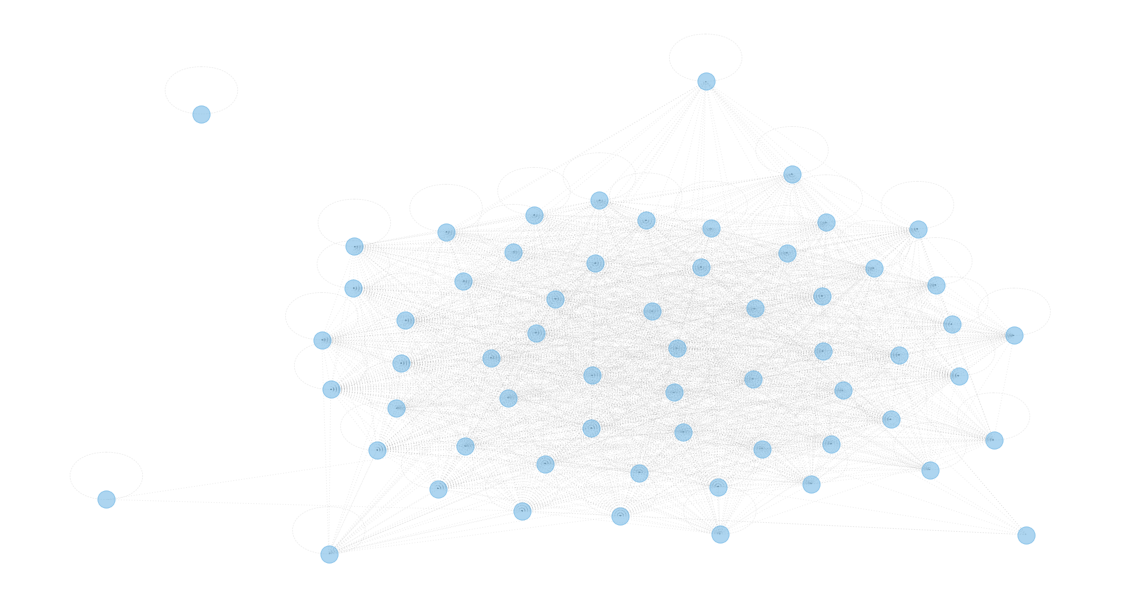

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))

# Positions
df_station["pos"] = list(zip(df_station["long"].astype(float), df_station["lat"].astype(float)))
pos = df_station.to_dict()['pos']

for node, position in pos.items():
  try:
    U.nodes[node]['pos'] = position
  except KeyError:
    pass

pos = nx.spring_layout(U,k=2)
nx.draw_networkx_nodes(U,pos, node_color=BLUE, alpha=0.5)
nx.draw_networkx_edges(U,pos, edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
ax.axis('off')

# Create Directed Graph

In [ ]:
G = nx.DiGraph()

## Nodes

In [ ]:
node_list = [(k, v) for k, v in df_station.to_dict('index').items()]
G.add_nodes_from(node_list)

## Edges

In [ ]:
edge_list = df_trip[['from_station_id','to_station_id']].to_numpy()

In [ ]:
for edge in edge_list:
  G.add_edge(edge[0], edge[1])

## Drawing Graph

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))

pos = nx.spring_layout(G,k=2)
nx.draw_networkx_nodes(G,pos, node_color=BLUE, alpha=0.5, node_size= 30)
nx.draw_networkx_edges(G,pos, edge_color='grey', style ="dotted", alpha=0.1, arrows=False)
ax.axis('off')

# Analyzing Graph

### Degree, Average Degree and Degree Distribution

In [ ]:
degrees = pd.DataFrame({"in-degree": ins, "out-degree": outs})
fig = sns.jointplot(x="in-degree",y="out-degree",data=degrees,kind="kde", color = 'darkblue',size=8)

NameError: ignored

In [ ]:
g_ins = [d for (n, d) in G.in_degree()]
g_outs = [d for (n, d) in G.out_degree()]
u_degree_sequence = sorted([d for n, d in U.degree()], reverse=True)

in_h = Counter(g_ins)
in_dic = collections.OrderedDict(sorted(in_h.items()))
in_hist = list(in_dic.values())
in_values =list(in_dic.keys())

out_h =  Counter(g_outs)
out_dic = collections.OrderedDict(sorted(out_h.items()))
out_hist = list(out_dic.values())
out_values =list(out_dic.keys())

In [ ]:
def g_degree_dist(degree_hist, degree_type):
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title(f'Directed Graph - {degree_type}-Degree Distribution')
    
    plt.show()

In [ ]:
def u_degree_dist(G):
    degree_hist = nx.degree_histogram(G) 
    degree_hist = np.array(degree_hist, dtype=float)
    degree_prob = degree_hist/G.number_of_nodes()
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(np.arange(degree_prob.shape[0]), degree_prob, 'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('p(k)')
    axes.set_title('Unirected Graph - Degree Distribution')
    
    plt.show()

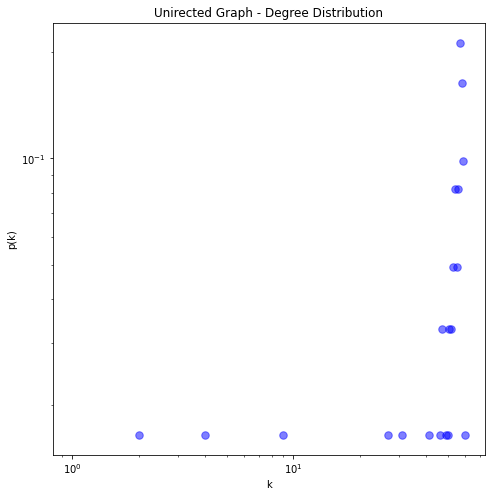

In [ ]:
u_degree_dist(U)

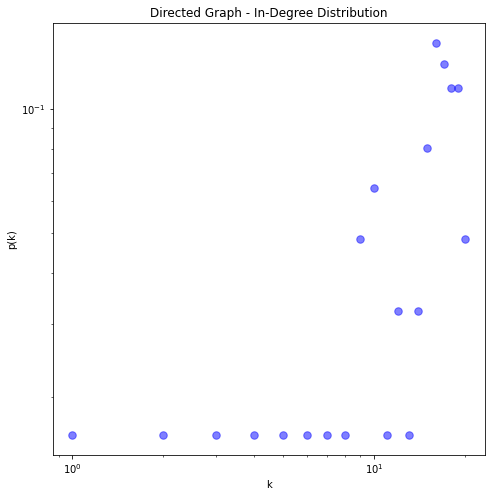

In [ ]:
g_degree_dist(in_hist, 'In')

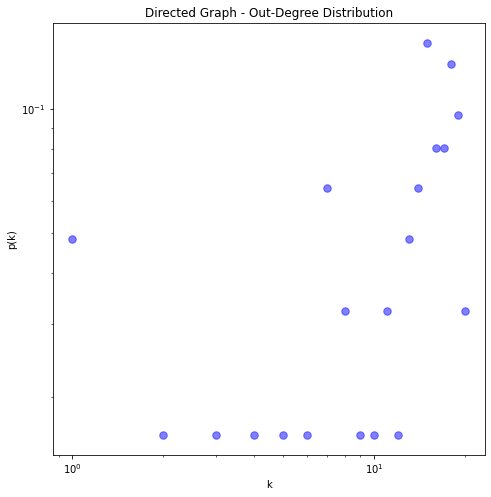

In [ ]:
g_degree_dist(out_hist, 'Out')

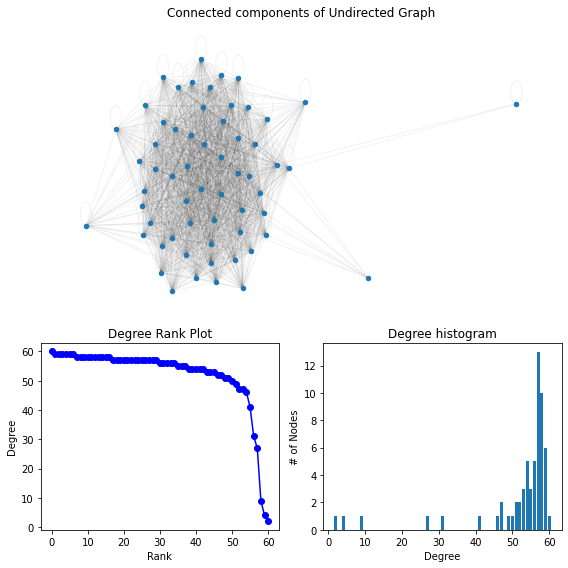

In [ ]:
dmax = max(u_degree_sequence)
fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = U.subgraph(sorted(nx.connected_components(U), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.05)
ax0.set_title("Connected components of Undirected Graph")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(u_degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(u_degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

NameError: ignored

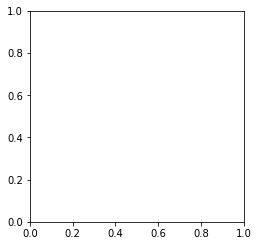

In [ ]:
fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(6, 4)

ax1 = fig.add_subplot(axgrid[0:3, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("In-Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[0:3, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("In-Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

ax3 = fig.add_subplot(axgrid[3:, :2])
ax3.plot(degree_sequence, "b-", marker="o")
ax3.set_title("Out-Degree Rank Plot")
ax3.set_ylabel("Degree")
ax3.set_xlabel("Rank")

ax4 = fig.add_subplot(axgrid[3:, 2:])
ax4.bar(*np.unique(degree_sequence, return_counts=True))
ax4.set_title("Out-Degree histogram")
ax4.set_xlabel("Degree")
ax4.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

### Graph Density
A first measure of the structure of a network is the so called density which measure how many links from all possible links within the network are realized.
The density is 0 if there are no edges, called empty graph and 1 if we have a complete Graph, all possible links between nodes are established.

In [ ]:
def networkStats(G):
    """
    This function prints the basic properties of the network.
    """
    print(nx.info(G))
    print("L-max =",(int((G.number_of_nodes()*(G.number_of_nodes()-1))/2)))
    if not nx.is_directed(G):
      if nx.is_connected(G):
        print ('Diameter: %s' % nx.diameter(G)) # print diameter of the network
      else:
          print ('Graph not connected: infinite path length')
          print ('Size of largest component: %s' % len(max(nx.connected_components(G), key=len)))

    density = nx.density(G)
    print("Network density:", density)
    triadic_closure = nx.transitivity(G)
    print("Triadic closure:", triadic_closure)
    print ('Degree Assortativity Coefficient (r): %s' % nx.degree_assortativity_coefficient(G))

    if not nx.is_directed(G):
      degree_dict = dict(G.degree(G.nodes()))
      nx.set_node_attributes(G, degree_dict, 'degree')

      sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)
      print("\nTop 5 nodes by degree:\n")
      for d in sorted_degree[:5]:
          print(d)

    else:
      print ('Graph not connected: infinite path length')

      in_degree_dict = dict(G.in_degree(G.nodes()))
      out_degree_dict = dict(G.out_degree(G.nodes()))
      nx.set_node_attributes(G, in_degree_dict, 'in-degree')
      nx.set_node_attributes(G, out_degree_dict, 'ou-degree')

      sorted_in_degree = sorted(in_degree_dict.items(), key=itemgetter(1), reverse=True)
      sorted_out_degree = sorted(out_degree_dict.items(), key=itemgetter(1), reverse=True)
      print("\nTop 5 nodes by in-degree:\n")
      for d in sorted_in_degree[:5]:
          print(d)
      print("\nTop 5 nodes by out-degree:\n")
      for d in sorted_out_degree[:5]:
          print(d)

    betweenness_dict = nx.betweenness_centrality(G) # Compute betweenness centrality
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    print("\nTop 5 nodes by betweenness centrality:\n")
    for b in sorted_betweenness[:5]:
        print(b)

In [ ]:
networkStats(U)
print("\n----------------\n")
networkStats(G)

Graph with 61 nodes and 1584 edges
L-max = 1830
Graph not connected: infinite path length
Size of largest component: 60
Network density: 0.8655737704918033
Triadic closure: 0.9322115323834688
Degree Assortativity Coefficient (r): 0.004079171493044617

Top 5 nodes by degree:

('Lake Union Park / Valley St & Boren Ave N', 60)
('E Pine St & 16th Ave', 59)
('Fred Hutchinson Cancer Research Center / Fairview Ave N & Ward St', 59)
('REI / Yale Ave N & John St', 59)
('Dexter Ave N & Aloha St', 59)

Top 5 nodes by betweenness centrality:

('Terry Ave & Stewart St', 0.02101580624202878)
('City Hall / 4th Ave & James St', 0.018551344501962736)
('Lake Union Park / Valley St & Boren Ave N', 0.005914565907303892)
('12th Ave & E Denny Way', 0.005658458268190034)
('Dexter Ave N & Aloha St', 0.005647487240525829)

----------------

DiGraph with 62 nodes and 2944 edges
L-max = 1891
Network density: 0.7784241142252777
Triadic closure: 0.9005854037482487
Degree Assortativity Coefficient (r): 1.0000000000

### Betweenness Centrality

In [ ]:
def betweenness_centrality(Graph,GraphType): 
    """
    This function plots the city bike network betweenes centrality
    """
    
    G = Graph.copy(as_view=False)
        
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))
    
   

    betweenness = nx.betweenness_centrality(G)
    node_color = [betweenness[i] for i in betweenness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color) - (sum(node_color)/len(node_color))
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title(f'{GraphType} Graph - Betweenness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

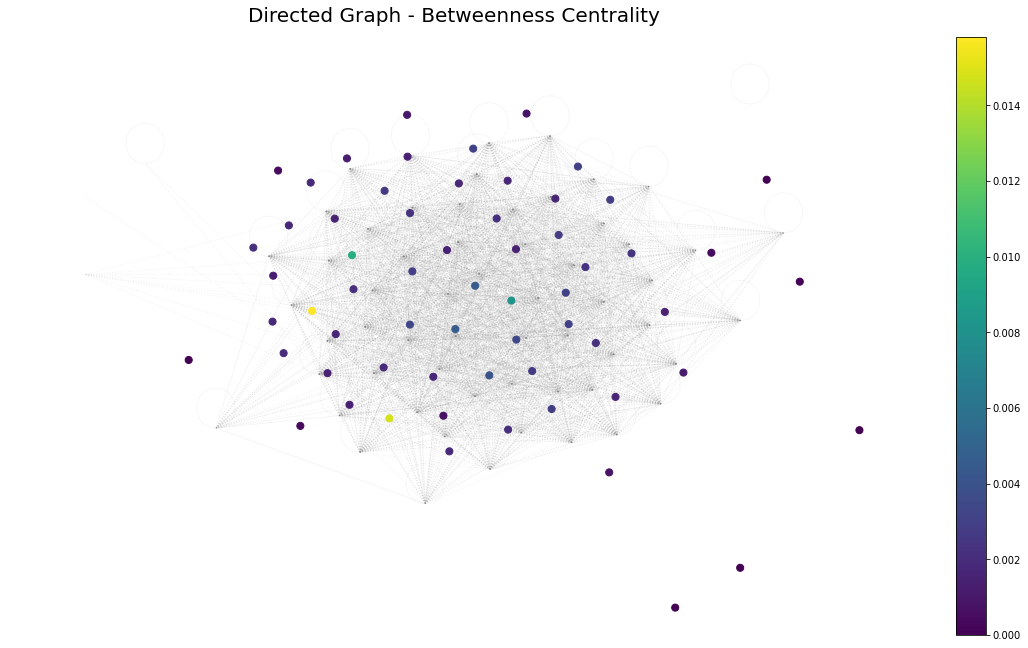

In [ ]:
betweenness_centrality(G, 'Directed')

In [ ]:
 betweenness = nx.betweenness_centrality(U)

In [ ]:
max_node, max_bc = max(betweenness.items(), key=lambda x: x[1])
max_node, max_bc

('Terry Ave & Stewart St', 0.02101580624202878)

In [ ]:
betweenness_centrality(U, 'Undirected')

### Degree Centrality

In [ ]:
def degree_centrality(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.degree_centrality(G)
    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Undirected Graph - Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

In [ ]:
def in_Degree_centrality(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.in_degree_centrality(G)

    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Directed Graph - In-Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

In [ ]:
def out_Degree_centrality(G):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    degree = nx.out_degree_centrality(G)

    node_color = [degree[i] for i in degree.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title('Directed Graph - Out-Degree Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

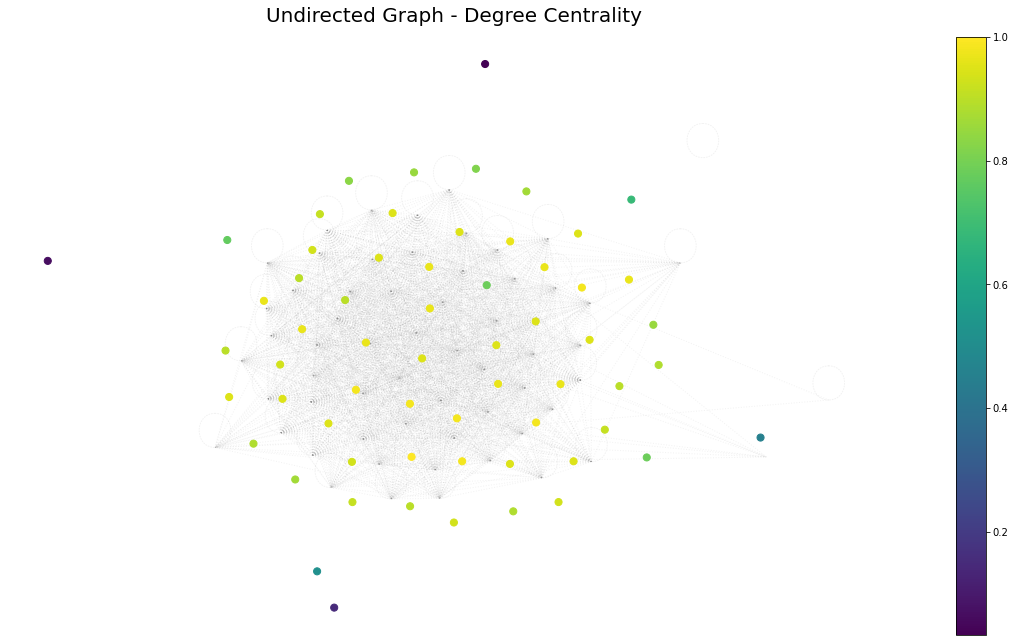

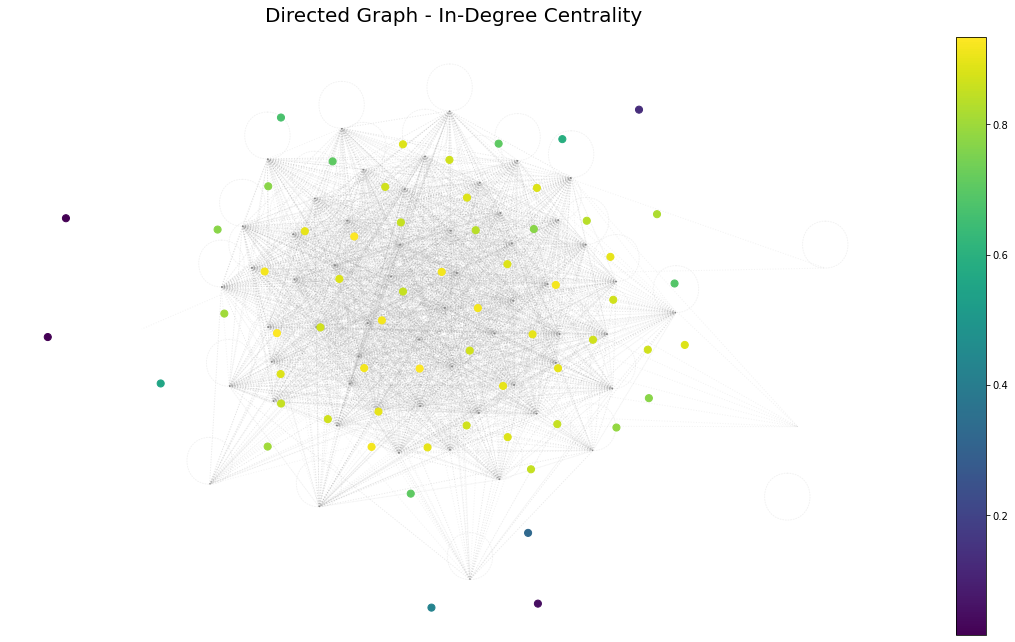

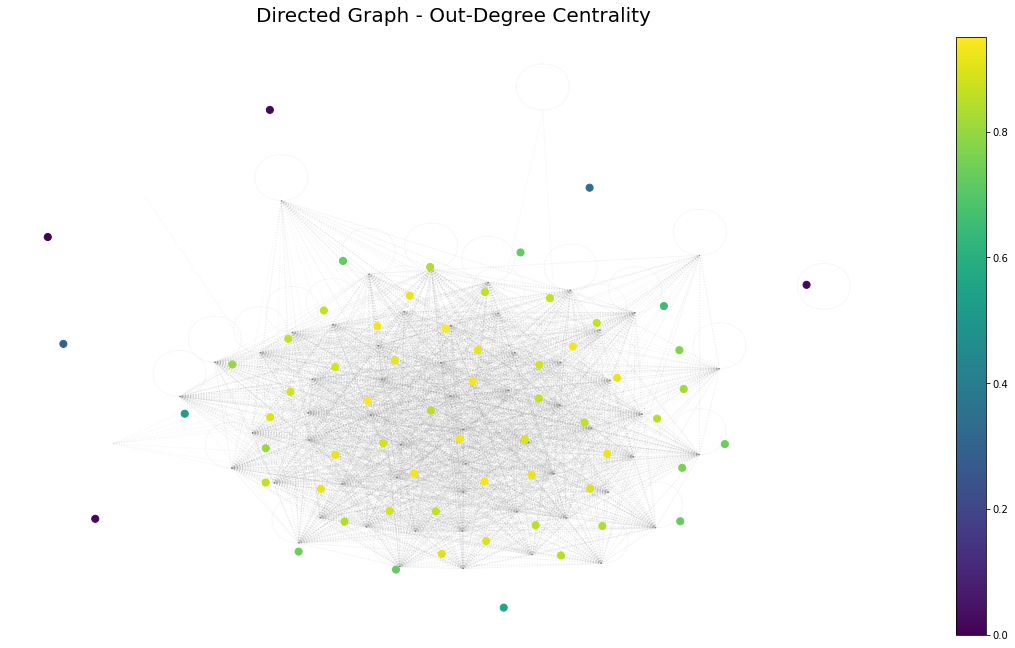

In [ ]:
degree_centrality(U)
in_Degree_centrality(G)
out_Degree_centrality(G)

### Closeness Centrality

In [ ]:
def closeness_centrality(G,GraphType):
    """
    This function plots an interactive City bike network with node degrees
    """
    # Figure
    fig, ax = plt.subplots(figsize=(20,11))

    closeness = nx.closeness_centrality(G)
    node_color = [closeness[i] for i in closeness.keys()]

    # Color scale
    colors=range(20)
    cmap=plt.cm.viridis
    vmin = min(node_color)
    vmax = max(node_color)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
    sm._A = []
    plt.colorbar(sm)

    # Draw
    nx.draw_networkx_nodes(G=G, pos=nx.spring_layout(G,k=2) ,node_color=node_color,cmap="viridis", alpha=1, node_size= 50)
    nx.draw_networkx_edges(G=G, pos=nx.spring_layout(G,k=2) ,edge_color='grey', style ="dotted", alpha=0.1, arrows=False)

    # Labeling Axes
    ax.set_title(f'{GraphType} Graph - Closeness Centrality', fontdict={"fontsize":20}, pad = 15)
    ax.axis('off')

In [ ]:
closeness_centrality(U, 'Undirected')
closeness_centrality(G, 'Directed')

In [ ]:
 closeness = nx.closeness_centrality(U)
max_node, max_bc = max(closeness.items(), key=lambda x: x[1])
max_node, max_bc

('Lake Union Park / Valley St & Boren Ave N', 0.9669444444444444)

### Clustering Coefficient

In [ ]:
def plot_clustering_coefficient(G, GraphType):
    clustering_dict = {}
    for node in G.nodes():
        k = G.degree(node)
        if not k in clustering_dict:
            clustering_dict[k] = [nx.clustering(G,node)]
        else:
            clustering_dict[k].append(nx.clustering(G,node))
    k_lst = sorted(clustering_dict.keys())
    clustering_lst = []
    for k in k_lst:
        clustering_lst.append(np.array(clustering_dict[k]).mean())
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,clustering_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('C(k)')
    axes.set_title(f'{GraphType} Graph - Average clustering coefficient')
    
    plt.show()

Average Clustering Coefficient of Directed Graph: 0.883



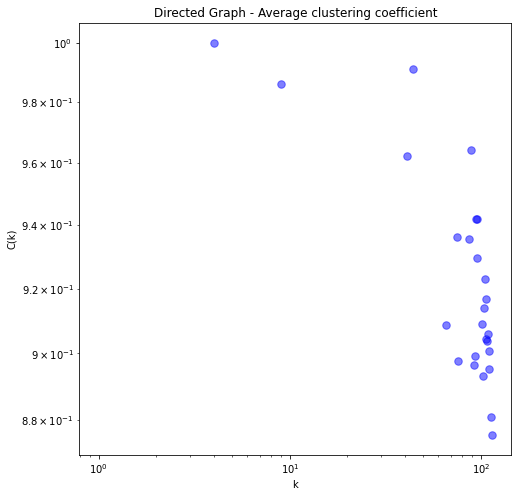

Average Clustering Coefficient of Unirected Graph: 0.922



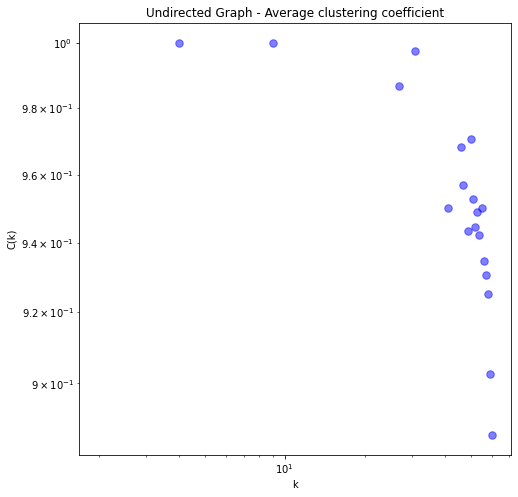

In [ ]:
print (f"Average Clustering Coefficient of Directed Graph: {round(nx.average_clustering(G),3)}\n") 
plot_clustering_coefficient(G, 'Directed')
print (f"Average Clustering Coefficient of Unirected Graph: {round(nx.average_clustering(U),3)}\n") 
plot_clustering_coefficient(U, 'Undirected')

### Community Detection

#### Girvan Newman method

In [ ]:
from networkx.algorithms import community
import itertools

In [ ]:
communities_list =[]
k = 1
comp = community.girvan_newman(G)
for communities in itertools.islice(comp, k):
    print(tuple(sorted(c) for c in communities))
    communities_list.append(tuple(sorted(c) for c in communities))

(['BT-01', 'BT-03', 'BT-04', 'BT-05', 'CBD-03', 'CBD-04', 'CBD-05', 'CBD-06', 'CBD-07', 'CBD-13', 'CD-01', 'CH-01', 'CH-02', 'CH-03', 'CH-05', 'CH-06', 'CH-07', 'CH-08', 'CH-09', 'CH-12', 'CH-15', 'CH-16', 'DPD-01', 'DPD-03', 'EL-01', 'EL-03', 'EL-05', 'FH-01', 'FH-04', 'ID-04', 'PS-04', 'PS-05', 'Pronto shop', 'Pronto shop 2', 'SLU-01', 'SLU-02', 'SLU-04', 'SLU-07', 'SLU-15', 'SLU-16', 'SLU-17', 'SLU-18', 'SLU-19', 'SLU-20', 'SLU-21', 'SLU-22', 'UD-01', 'UD-02', 'UD-04', 'UD-07', 'UW-01', 'UW-02', 'UW-04', 'UW-06', 'UW-07', 'UW-10', 'UW-11', 'WF-01', 'WF-03', 'WF-04'], ['SLU-15trip_id"'], ['8D OPS 02'])


In [ ]:
community_index = {}
for communities in communities_list:
  for i,community in enumerate(communities):
    for node in community:
      community_index[node] = i

In [ ]:
nx.set_node_attributes(G, community_index, "community")

(-1.125221397238759, 1.065178039760659, -1.188041710336024, 1.1041924623969535)

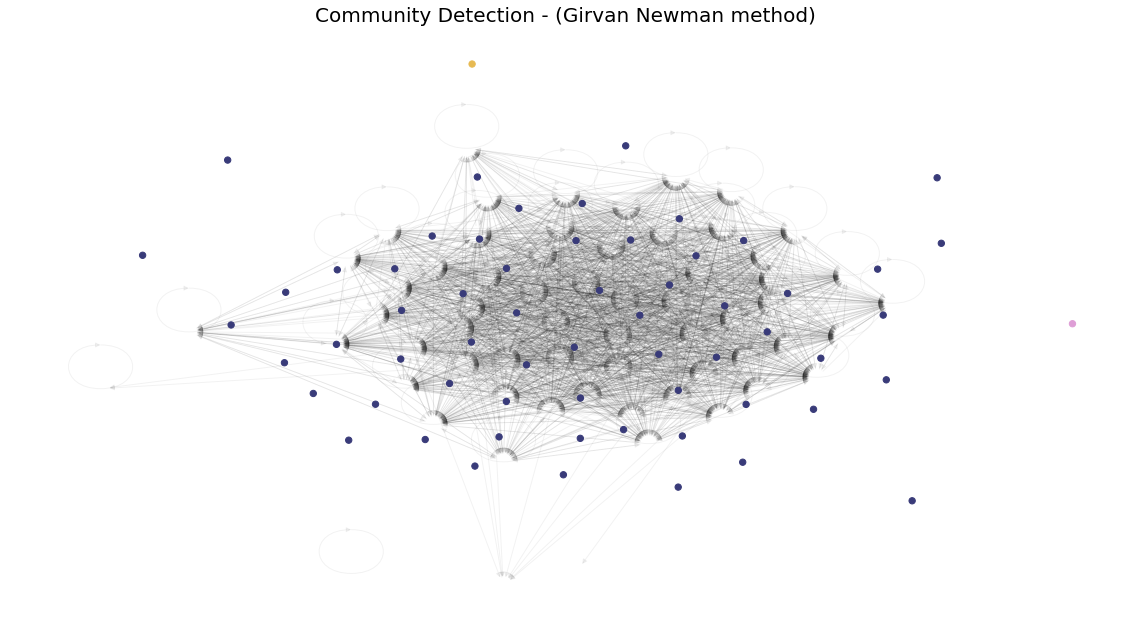

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))

cmap = cm.get_cmap('tab20b', max(community_index.values()) + 1)

# Draw Nodes & Edges
nx.draw_networkx_nodes(G, 
                       pos=nx.spring_layout(G,k=2),
                       nodelist=community_index.keys(), 
                       node_size=40, 
                       cmap=cmap,
                       node_color=list(community_index.values()))
nx.draw_networkx_edges(G, pos=nx.spring_layout(G,k=2), alpha=0.05)

# Labeling Axes
ax.set_title('Community Detection - (Girvan Newman method)', fontdict={"fontsize":20}, pad = 15)
ax.axis('off')

#### Label Propagation method

In [ ]:
from networkx.algorithms.community import label_propagation

In [ ]:
communities=label_propagation.label_propagation_communities(U)

In [ ]:
community_index = {}
for community_number,community in enumerate(communities):
  for node in community:
    community_index[node]=community_number

In [ ]:
nx.set_node_attributes(U, community_index, "community")

(-0.748608616573661, 1.166157379855416, -0.991183289075031, 0.857182645199074)

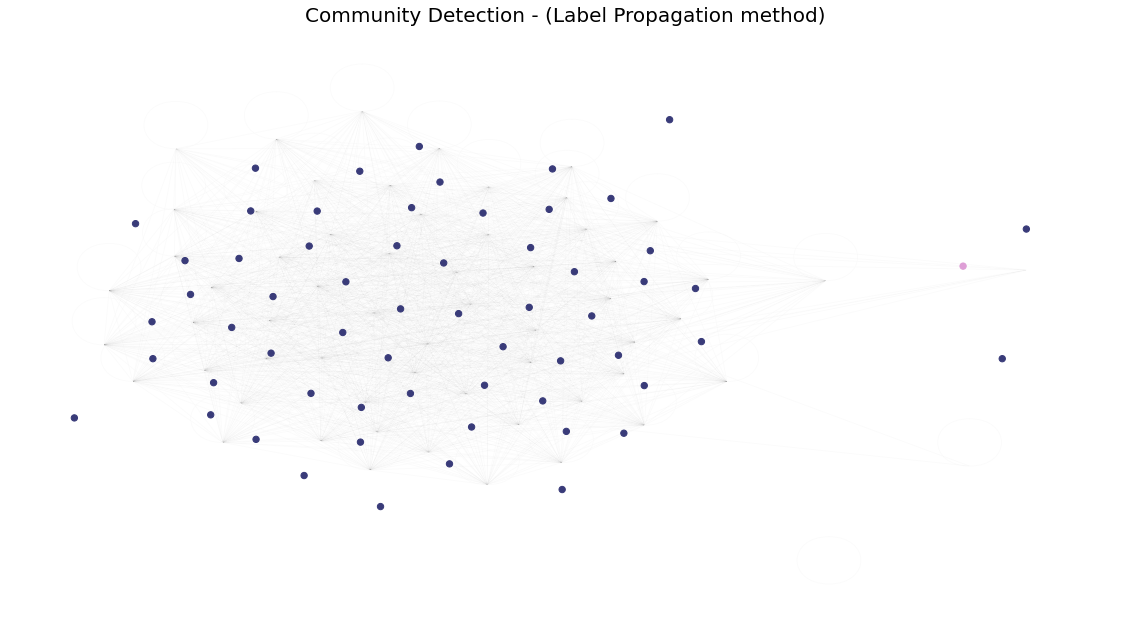

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))

cmap = cm.get_cmap('tab20b', max(community_index.values()) + 1)

# Draw Nodes & Edges
nx.draw_networkx_nodes(U, 
                       pos=nx.spring_layout(U,k=2),
                       nodelist=community_index.keys(), 
                       node_size=40, 
                       cmap=cmap,
                       node_color=list(community_index.values()))
nx.draw_networkx_edges(U, pos=nx.spring_layout(U,k=2), alpha=0.015)

# Labeling Axes
ax.set_title('Community Detection - (Label Propagation method)', fontdict={"fontsize":20}, pad = 15)
ax.axis('off')

### knn- K Nearest Neighbors
Compute the average degree connectivity of graph.

The average degree connectivity is the average nearest neighbor degree of
nodes with degree k.

In [ ]:
def fit_func(x,a,mu):
    return (a*x)**mu

In [ ]:
def plot_knn(G, GraphType, fit=True): 
    knn_dict = nx.average_degree_connectivity(G) # k_nearest_neighbors return dict with knn for each k
    k_lst = sorted(knn_dict.keys())
    knn_lst = []
    for k in k_lst:
        knn_lst.append(knn_dict[k])
    
    # plotting
    fig = plt.figure(figsize=(6,6))
    axes = fig.add_axes([1,1,1,1])
    
    axes.loglog(k_lst,knn_lst,'b.', markersize=15, alpha=0.5)
    
    axes.set_xlabel('k')
    axes.set_ylabel('knn(k)')
    axes.set_title(f'{GraphType} Graph - Average next neighbor degree')
    
    if fit:
        # fit a*x^mu
        popt, pcov = curve_fit(fit_func, np.array(k_lst), np.array(knn_lst))
        axes.loglog(np.array(k_lst), fit_func(np.array(k_lst), *popt), '--', c='gray')
    
    plt.show()

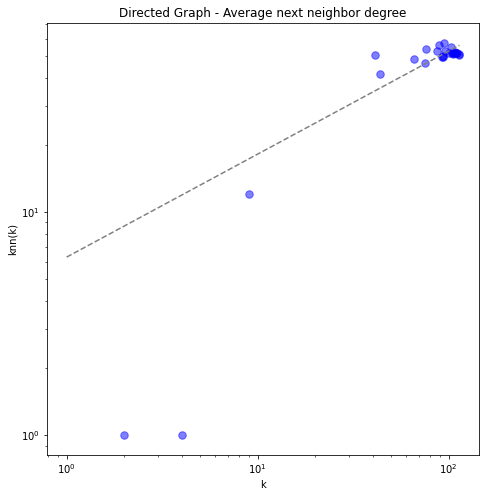

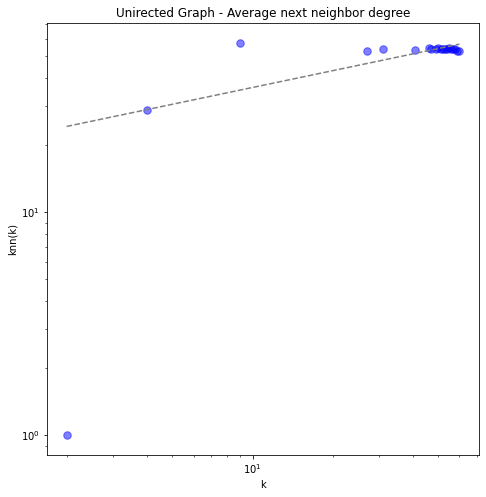

In [ ]:
plot_knn(G, 'Directed')
plot_knn(U, 'Unirected')